<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

#  Class Imbalances 1: EDA

_Author_: Dan Wilhelm (LA)
    
---

### Pre-lesson Install

> In this notebook, we will use the library `imbalanced-learn` to help us resample our training and test data. ([Docs](https://imbalanced-learn.org/stable/user_guide.html))

> Install it by running: `conda install -c conda-forge imbalanced-learn`

Today we'll cover techniques for:

- Organizing larger projects.
- Handling class imbalance.
- Optimizing models for precision/recall rather than accuracy.

Because this is a larger project than usual, there is no solution notebook. All code is contained inside the lesson notebooks.

# Learning Objectives

1. Utilize external Python files and pickling to organize larger projects.
2. Explain the use of recall and precision in evaluating model performance.
3. Explain techniques for dealing with class imbalance.
4. Practice maximizing recall while balancing precision, instead of maximizing accuracy.

# EDA Outline

1. [Business Objective](#objective)
2. [EDA](#eda)
3. [Vectorize Data for ML](#vectorize)
4. [Moving Results to Another Notebook](#save)

---

<a id="objective"></a>
# Business Objective

**Business Case:**
+ We want to identify customers who make >50K/year, in order to send them special marketing materials.

**Business Considerations:**

+ Do not care about interpretability.

<details><summary>Q: Would you prioritize false positives or false negatives, if you must choose? Why?</summary>

+ **False positives**  (i.e. we guess >50K/year but are wrong) are okay.
    - _Why?_ These likely will be close to the income level, and marketing materials are cheap.
+ **False negatives** (i.e. we guess <=50K/year but are wrong) are less preferable.
    - _Why?_ We will be losing out on potential customers and not saving much on the materials to justify it.
</details>

**Objective:**
+ Predict who will make >50K vs. <=50K per year (1994 dollars)
    - We immediately see this requires a **binary classifier**.
+ Optimize for false positives, if it proves beneficial.

**Decided-on pipeline:**
+ This dataset is tricky. The classes are imbalanced, and the train/test sets are different!
+ Using sklearn transformers, we will vectorize train and test data identically.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# Reloads adult_data.py every time a function is called from it.
# This is *very* useful for editing the file as you work!
import autoreload
%load_ext autoreload
%autoreload 2

import adult_data as ad    # Helper functions in the current directory!

# CONSTANTS
ADULT_TRAIN_FILE = './data/adult.data'
ADULT_TEST_FILE = './data/adult.test'

OUTPUT_PICKLE_FILE = 'adult_data-vec.pickle'

# Load & Clean Data

Most of this code was moved into `adult_data.py`.
This allows for:
- reuse in many notebooks, and 
- reduction of notebook complexity.

In [4]:
adult_train_df, adult_test_df = \
    ad.load_train_test(ADULT_TRAIN_FILE, ADULT_TEST_FILE, verbose=True)

Train shape:  (30162, 15)
Test shape:  (15060, 15)


In [5]:
# Remember: just because they're non-null doesn't mean they're valid!

#   It was found via experimentation that the only unknown values are
#    indicated by a `"?"` in `occupation`, `native_country`, and `workclass`.

#   Luckily, we noticed this and cleaned them first inside `load_train_test`.

adult_train_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education_num   30162 non-null  int64 
 5   marital_status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital_gain    30162 non-null  int64 
 11  capital_loss    30162 non-null  int64 
 12  hours_per_week  30162 non-null  int64 
 13  native_country  30162 non-null  object
 14  income          30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


<a id="eda"></a>
# EDA

In [6]:
df = adult_train_df.copy()
df, DUMMY_COLUMNS = ad.dummify_features(df, verbose=True)  # Returns set of new dummy column names

Dummies shape:  (30162, 98)


In [7]:
# Remember: by default, `describe` only looks at numerical columns
df[ad.ADULT_COLUMNS].describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Starting from these base statistics, we start analyzing the data as follows:

1. Make a hypothesis that you would expect to be true.
2. Test your hypothesis!

This method will eventually yield some interesting findings.

In [8]:
# We'd expect the target income classes to be 50-50 <50K / >=50K
# NO! -- CLASS IMBALANCE!

#  <=50K - 75%, >50K - 25%

df.income.value_counts(normalize=True)

<=50K    0.751078
>50K     0.248922
Name: income, dtype: float64

In [9]:
# We'd expect the genders to be around 50-50 M/F
# NO!

# M - 68%, F - 32%

df.sex.value_counts(normalize=True)

Male      0.675685
Female    0.324315
Name: sex, dtype: float64

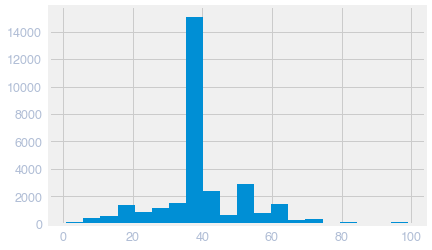

In [10]:
# We'd expect hours per week to be around 40
# VERIFIED.

# Remember: Must use brackets since `-` is not a valid character in identifiers
df.hours_per_week.hist(bins=20);

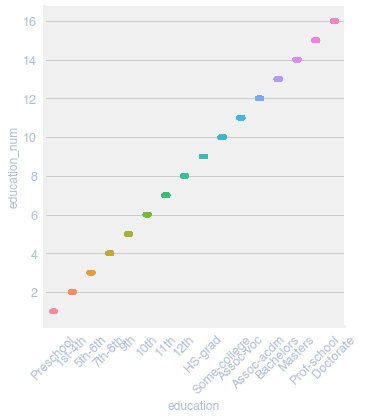

In [11]:
# We'd expect `education-num` to correspond exactly to specific `education` categories
# VERIFIED.

chart = sns.catplot(x='education', y='education_num',
            data=df.sort_values('education_num'));

chart.set_xticklabels(rotation=45);

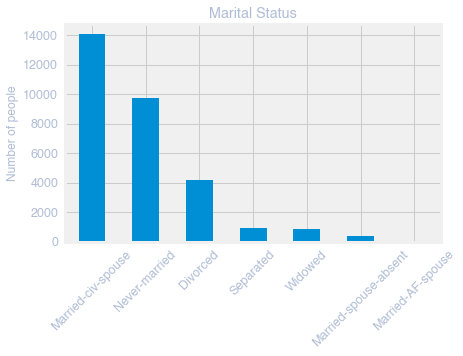

In [12]:
# Let's look at marital status and derive a hypothesis from it.
# Hint: Instead of only showing value counts as numbers, show a plot!

df.marital_status.value_counts().plot(kind='bar', rot=45);
plt.ylabel('Number of people');
plt.title('Marital Status');

# From this: 
#  Hypothesize that married have higher incomes 
#        (check whether income is household or individual!)

In [13]:
df.native_country.value_counts()

United-States                 27504
Mexico                          610
Philippines                     188
Germany                         128
Puerto-Rico                     109
Canada                          107
India                           100
El-Salvador                     100
Cuba                             92
England                          86
Jamaica                          80
South                            71
China                            68
Italy                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        63
Japan                            59
Poland                           56
Columbia                         56
Haiti                            42
Iran                             42
Taiwan                           42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                           29
France                      

---

This is just the beginning! 

I recommend continuing your EDA until you are prepared to answer any question about the data stakeholders might be curious about -- especially if it's related to your presentation.

# A Few EDA Tips/Gotchas

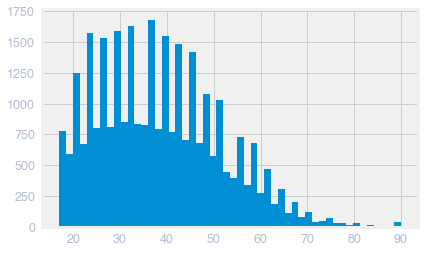

In [14]:
# Be careful with histograms -- they are often misleading!
df.age.hist(bins=50);

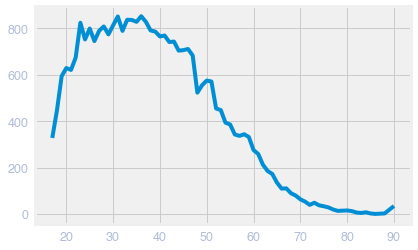

In [15]:
# Actual distribution
df.age.value_counts().sort_index().plot();

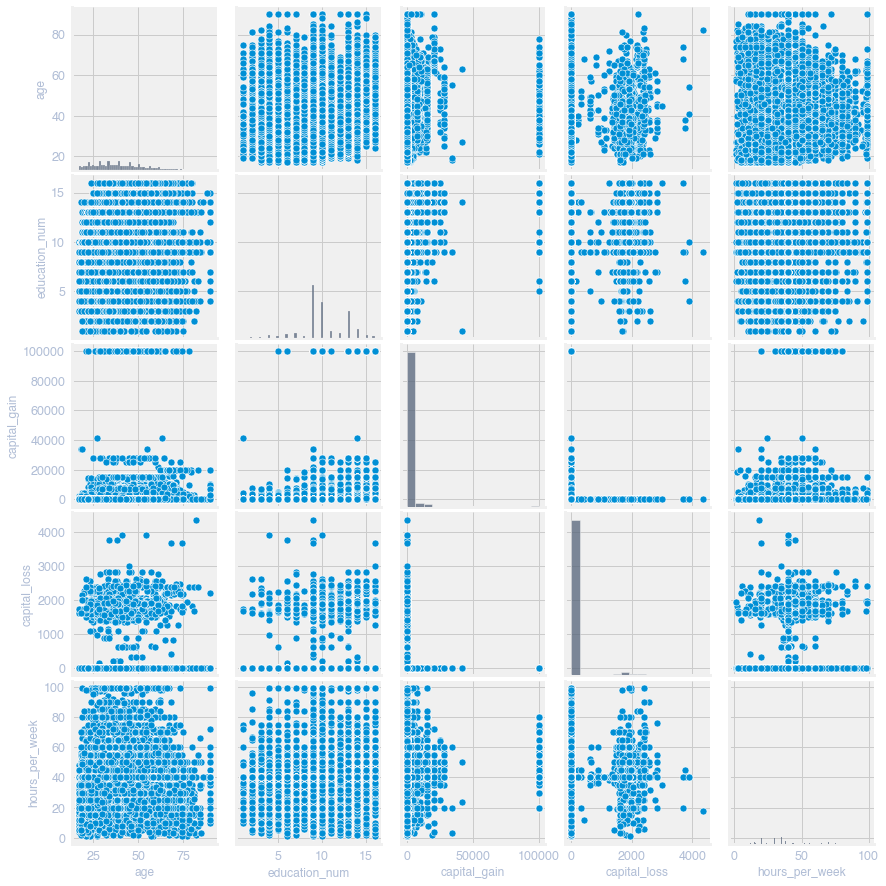

In [16]:
# Always a good idea to look at how each numerical feature is distributed

NUMERICAL_FEATURES = ['age', 'education_num', 'capital_gain', 
                      'capital_loss', 'hours_per_week']

sns.pairplot(df[NUMERICAL_FEATURES]);

Takeaways:
+ **age** 
    - fairly mound-like
+ **hours_per_week** 
    - fairly mound-like
+ **education_num** 
    - mostly three values 
+ **capital_gain**
    - nearly all zero. Many outliers. Long-tail.
+ **capital_loss**
    - nearly all zero. Many outliers. Long-tail.

In [17]:
# Ideally we would create a heatmap here and restrict it to 
#   highly correlated values, but this is not the objective of this notebook
df.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_federal-gov,workclass_local-gov,workclass_private,workclass_self-emp-inc,...,native_country_portugal,native_country_puerto-rico,native_country_scotland,native_country_south,native_country_taiwan,native_country_thailand,native_country_trinadad&tobago,native_country_united-states,native_country_vietnam,native_country_yugoslavia
age,1.000000,-0.076511,0.043526,0.080154,0.060165,0.101599,0.056626,0.068256,-0.210491,0.111039,...,0.001062,0.007836,0.000024,0.001923,-0.007879,-0.004940,0.007868,0.016259,-0.017775,0.000657
fnlwgt,-0.076511,1.000000,-0.044992,0.000422,-0.009750,-0.022886,-0.006932,-0.003520,0.046589,-0.025496,...,-0.014020,0.007121,-0.003055,-0.010598,0.001615,-0.001241,-0.000413,-0.083390,-0.010761,0.005707
education_num,0.043526,-0.044992,1.000000,0.124416,0.079646,0.152522,0.058244,0.097378,-0.165069,0.078843,...,-0.043058,-0.042083,0.001815,0.017812,0.049129,0.008183,-0.017134,0.127207,-0.010953,-0.001661
capital_gain,0.080154,0.000422,0.124416,1.000000,-0.032229,0.080432,-0.006299,-0.009624,-0.048185,0.096482,...,-0.003826,-0.006270,-0.002816,-0.002582,0.007639,-0.003501,-0.003603,0.012375,-0.002493,-0.002317
capital_loss,0.060165,-0.009750,0.079646,-0.032229,1.000000,0.052417,0.010380,0.014727,-0.036377,0.030956,...,-0.007343,-0.004560,-0.004175,0.005677,0.005679,-0.005191,0.008849,0.015119,0.000344,-0.005036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
native_country_thailand,-0.004940,-0.001241,0.008183,-0.003501,-0.005191,0.012846,-0.004266,-0.006441,-0.008144,0.018052,...,-0.000798,-0.001430,-0.000454,-0.001154,-0.000887,1.000000,-0.000580,-0.076390,-0.001095,-0.000547
native_country_trinadad&tobago,0.007868,-0.000413,-0.017134,-0.003603,0.008849,-0.007566,-0.004390,-0.001255,0.002164,0.002630,...,-0.000821,-0.001472,-0.000467,-0.001187,-0.000913,-0.000580,1.000000,-0.078606,-0.001127,-0.000563
native_country_united-states,0.016259,-0.083390,0.127207,0.012375,0.015119,0.010673,0.017541,0.032937,-0.049809,0.007350,...,-0.108062,-0.193727,-0.061442,-0.156254,-0.120121,-0.076390,-0.078606,1.000000,-0.148334,-0.074108
native_country_vietnam,-0.017775,-0.010761,-0.010953,-0.002493,0.000344,-0.010381,-0.000004,-0.003952,0.009369,-0.004973,...,-0.001549,-0.002777,-0.000881,-0.002240,-0.001722,-0.001095,-0.001127,-0.148334,1.000000,-0.001062


<a id="vectorize"></a>
# Vectorize Data for ML

In [18]:
df.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_federal-gov,workclass_local-gov,workclass_private,workclass_self-emp-inc,...,native_country_portugal,native_country_puerto-rico,native_country_scotland,native_country_south,native_country_taiwan,native_country_thailand,native_country_trinadad&tobago,native_country_united-states,native_country_vietnam,native_country_yugoslavia
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,...,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238,0.031265,0.068530,0.738877,0.035608,...,0.001127,0.003614,0.000365,0.002354,0.001392,0.000564,0.000597,0.911876,0.002122,0.000530
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984,0.174035,0.252657,0.439254,0.185313,...,0.033556,0.060007,0.019094,0.048461,0.037291,0.023734,0.024422,0.283480,0.046016,0.023026
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# Vectorize train and test sets! (We mostly just dummify the categorical features.)

X_train_df, y_train, encoders = ad.vectorize(adult_train_df)
X_test_df, y_test, encoders = ad.vectorize(adult_test_df, encoders=encoders)

print('encoders:', encoders)  # Easy way of storing all of the pre-fit encoders
print(f'X_train: {X_train_df.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test_df.shape}, y_test: {y_test.shape}')

X_train_df   # Just to look at what is passed into sklearn

encoders: {'categorical': OneHotEncoder(dtype=<class 'numpy.int64'>, sparse=False)}
X_train: (30162, 104), y_train: (30162,)
X_test: (15060, 104), y_test: (15060,)


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,39.0,77516.0,13.0,2174.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27.0,257302.0,12.0,0.0,0.0,38.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30158,40.0,154374.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30159,58.0,151910.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30160,22.0,201490.0,9.0,0.0,0.0,20.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<a id="save"></a>
# Moving Results to Another Notebook

We have cleaned and explored our data and are ready for modeling! However, this notebook is getting unwieldy. How can we move our results to the next notebook?

CSV is easy to read and write. However, CSV stores every column as text, is slow, and takes up a lot of space.

---

#### Pickling

Today, we'll try [*pickling*](https://docs.python.org/3/library/pickle.html). This dumps the DataFrame directly from your RAM to disk.
- **Pros:** 
    - _Fast_.
    - Uses minimal memory.
    - Preserves data types.
- **Cons:** 
    - Not human readable. 
    - Newer versions of Pandas may fail to read your files, if the underlying memory representation changes.

In [19]:
# Option 1: Pickle each individual DataFrame and Series
# - This only works for Pandas objects, nothing else!

X_train_df.to_pickle('X_train_df.pkl')
y_train.to_pickle('y_train.pkl')

X_test_df.to_pickle('X_test_df.pkl')
y_test.to_pickle('y_test.pkl')

In [20]:
# Option 2: Python standard library
# - Only requires one file
# - Can bundle multiple objects together in a dict.
import pickle

# Package the variables we want to export
data = {
    'train_file': ADULT_TRAIN_FILE,  # Record what was vectorized
    'test_file': ADULT_TEST_FILE,
    
    'encoders': encoders,            # For encoding additional test data
    
    'X_train_df': X_train_df,        # Train
    'y_train': y_train,
    
    'X_test_df': X_test_df,          # Test
    'y_test': y_test,
    }


# 'wb' - Write + Binary File
with open(OUTPUT_PICKLE_FILE, 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)